In [ ]:
import tensorflow as tf

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, BatchNormalization, LSTM, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2, l1, l1_l2


# from spektral.layers import GraphConv
# GRaphConv is deprecated, use GCNConv or GCSConv instead
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian
from spektral.layers import GCSConv  # as GraphConv
from spektral.layers import GINConv # as GraphConv
from spektral.layers import GCNConv  # as GraphConv

from spektral.utils.convolution import gcn_filter  # For GCNConv
from spektral.utils.convolution import normalized_adjacency  # For GCSConv

import numpy as np
import scipy.sparse
import pandas as pd
import pathlib
import os
import json

from sklearn.model_selection import train_test_split
from mediapipe.python.solutions.face_mesh_connections import FACEMESH_TESSELATION

from utils import *

import numpy as np


# Parameters
l2_reg = 5e-4
learning_rate = 1e-3
batch_size = 32
epochs = 5
es_patience = 200
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [3]:
def get_mediapipe_adjacency_matrix():
    """Create adjacency matrix from MediaPipe face mesh connections"""
    # MediaPipe face mesh has 468 landmarks
    n_nodes = 468
    adj_matrix = np.zeros((n_nodes, n_nodes), dtype=np.float32)
    
    # Add edges based on MediaPipe face mesh connections
    for connection in FACEMESH_TESSELATION:
        i, j = connection[0], connection[1]
        if i < n_nodes and j < n_nodes:  # Ensure indices are valid
            adj_matrix[i, j] = 1.0
            adj_matrix[j, i] = 1.0  # Undirected graph
    
    # Add self-loops
    np.fill_diagonal(adj_matrix, 1.0)
    
    return adj_matrix

def normalize_mesh_points(mesh_points):
    """Normalize mesh points to unit scale"""
    mesh_points = np.array(mesh_points, dtype=np.float32)
    
    # Center the points
    center = np.mean(mesh_points, axis=0)
    mesh_points = mesh_points - center
    
    # Scale to unit variance
    scale = np.std(mesh_points)
    if scale > 0:
        mesh_points = mesh_points / scale
    
    return mesh_points

def load_mesh_data(path_list, limit=1.0):
    """Load and preprocess mesh data from directories"""
    all_meshes = []
    all_labels = []
    
    for emotion_idx, path in enumerate(path_list):
        if not path.exists():
            print(f"Path does not exist: {path}")
            continue
            
        files = os.listdir(path)
        num_files = len(files)
        files_to_process = int(num_files * limit)
        
        emotion_meshes = []
        processed = 0
        
        for file in files[:files_to_process]:
            if not file.endswith('.json'):
                continue
                
            file_path = path / file
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    
                # Ensure we have exactly 468 landmarks
                if len(data) != 468:
                    print(f"Skipping {file}: expected 468 landmarks, got {len(data)}")
                    continue
                
                # Normalize the mesh points
                normalized_mesh = normalize_mesh_points(data)
                emotion_meshes.append(normalized_mesh)
                processed += 1
                
            except Exception as e:
                print(f"Error loading {file}: {e}")
                continue
        
        print(f"Loaded {processed} samples for emotion {emotion_idx}")
        
        # Add to overall lists
        all_meshes.extend(emotion_meshes)
        all_labels.extend([emotion_idx] * len(emotion_meshes))
    
    return np.array(all_meshes, dtype=np.float32), np.array(all_labels, dtype=np.int32)



In [4]:
# Define paths
current_path = pathlib.Path().absolute()
parent_path = current_path.parent

path_list = [
    parent_path / 'angry_meshpoints',
    parent_path / 'disgusted_meshpoints', 
    parent_path / 'happy_meshpoints',
    parent_path / 'neutral_meshpoints',
    parent_path / 'sad_meshpoints',
    parent_path / 'surprised_meshpoints'
]

emotion_names = ['angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

print("Loading mesh data...")
X_data, y_data = load_mesh_data(path_list, limit=1.0)

print(f"Total samples loaded: {len(X_data)}")
print(f"Data shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")

# Print class distribution
unique, counts = np.unique(y_data, return_counts=True)
for emotion_idx, count in zip(unique, counts):
    print(f"{emotion_names[emotion_idx]}: {count} samples")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, shuffle=True, random_state=RANDOM_SEED, stratify=y_data
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.5, shuffle=True, random_state=RANDOM_SEED, stratify=y_train
)

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Convert to TensorFlow tensors
X_train_tensor = tf.constant(X_train, dtype=tf.float32)
y_train_tensor = tf.constant(y_train, dtype=tf.int32)
X_val_tensor = tf.constant(X_val, dtype=tf.float32)
y_val_tensor = tf.constant(y_val, dtype=tf.int32)
X_test_tensor = tf.constant(X_test, dtype=tf.float32)
y_test_tensor = tf.constant(y_test, dtype=tf.int32)

print(f"Train tensor shape: {X_train_tensor.shape}")
print(f"Train labels shape: {y_train_tensor.shape}")

# Model parameters
n_out = 6  # Number of emotion classes
N = X_train_tensor.shape[1]  # Number of nodes (468)
F = X_train_tensor.shape[2]  # Feature dimensionality (2 for x,y coordinates)

print(f"Number of nodes: {N}")
print(f"Number of features per node: {F}")

# Create adjacency matrix
print("Creating adjacency matrix...")
adj_matrix = get_mediapipe_adjacency_matrix()
print(f"Adjacency matrix shape: {adj_matrix.shape}")
print(f"Number of edges: {np.sum(adj_matrix > 0) // 2}")  # Divide by 2 for undirected graph

# Convert to sparse tensor for efficiency
adj_sparse = scipy.sparse.csr_matrix(adj_matrix)
adj_tensor = sp_matrix_to_sp_tensor(adj_sparse)




Loading mesh data...
Loaded 7603 samples for emotion 0
Loaded 6176 samples for emotion 1
Loaded 8681 samples for emotion 2
Loaded 9579 samples for emotion 3
Loaded 7965 samples for emotion 4
Loaded 7719 samples for emotion 5
Total samples loaded: 47723
Data shape: (47723, 468, 2)
Labels shape: (47723,)
angry: 7603 samples
disgusted: 6176 samples
happy: 8681 samples
neutral: 9579 samples
sad: 7965 samples
surprised: 7719 samples
Train samples: 19089
Validation samples: 19089
Test samples: 9545
Train tensor shape: (19089, 468, 2)
Train labels shape: (19089,)
Number of nodes: 468
Number of features per node: 2
Creating adjacency matrix...
Adjacency matrix shape: (468, 468)
Number of edges: 1556


V1

In [5]:
from tensorflow.keras.layers import GlobalAveragePooling1D
# Build the GNN model
print("Building model...")
X_in = Input(shape=(N, F), name='node_features')

# First GNN layer
x = GINConv(64, activation="relu", kernel_regularizer=l2(l2_reg))([X_in, adj_tensor])
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Second GNN layer
x = GINConv(32, activation="relu", kernel_regularizer=l2(l2_reg))([x, adj_tensor])
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# # Global pooling (flatten all node features)
# x = Flatten()(x)

x = GlobalAveragePooling1D()(x)

# Fully connected layers
x = Dense(256, activation="relu", kernel_regularizer=l2(l2_reg))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation="relu", kernel_regularizer=l2(l2_reg))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(n_out, activation="softmax", name='emotion_output')(x)

# Create and compile model
model = Model(inputs=X_in, outputs=output)
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Building model...



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ node_features (InputLayer)      │ (None, 468, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gin_conv (GINConv)              │ (None, 468, 64)        │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 468, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 468, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gin_conv_1 (GINConv)            │ (None, 468, 32)        │         2,081 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 468, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 468, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ emotion_output (Dense)          │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,312 (180.91 KB)

 Trainable params: 45,352 (177.16 KB)

 Non-trainable params: 960 (3.75 KB)

v2


In [8]:
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, 
    GlobalAveragePooling1D, GlobalMaxPooling1D, Add, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from spektral.layers import GINConv

print("Building model...")

# Input
X_in = Input(shape=(N, F), name='node_features')

# --- GNN Layer 1 ---
x1 = GINConv(64, activation="relu", kernel_regularizer=l2(l2_reg))([X_in, adj_tensor])
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)

# --- GNN Layer 2 (same feature size for residual) ---
x2 = GINConv(64, activation="relu", kernel_regularizer=l2(l2_reg))([x1, adj_tensor])
x2 = BatchNormalization()(x2)
x2 = Dropout(0.3)(x2)

# --- Residual Connection ---
x = Add()([x1, x2])

# --- Hybrid Global Pooling (mean + max) ---
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = Concatenate()([avg_pool, max_pool])

# --- Fully connected layers ---
x = Dense(256, activation="relu", kernel_regularizer=l2(l2_reg))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation="relu", kernel_regularizer=l2(l2_reg))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# --- Output layer ---
output = Dense(n_out, activation="softmax", name='emotion_output')(x)

# --- Compile ---
model = Model(inputs=X_in, outputs=output)
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Building model...


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ node_features       │ (None, 468, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gin_conv_4          │ (None, 468, 64)   │        193 │ node_features[0]… │
│ (GINConv)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 468, 64)   │        256 │ gin_conv_4[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 468, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gin_conv_5          │ (None, 468, 64)   │      4,161 │ dropout_6[0][0]   │
│ (GINConv)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 468, 64)   │        256 │ gin_conv_5[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 468, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 468, 64)   │          0 │ dropout_6[0][0],  │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ add_1[0][0]       │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │     33,024 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     32,896 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output      │ (None, 6)         │        774 │ dropout_9[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,096 (285.53 KB)

 Trainable params: 72,072 (281.53 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Starting training...")

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=es_patience,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Training
history = model.fit(
    X_train_tensor,
    y_train_tensor,
    batch_size=batch_size,
    validation_data=(X_val_tensor, y_val_tensor),
    epochs=epochs * 2,  # doubling epochs with early stopping is fine
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("✅ Training completed!")


Starting training...
Epoch 1/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.2182 - loss: 2.3253 - val_accuracy: 0.1865 - val_loss: 2.4451 - learning_rate: 0.0010
Epoch 2/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.2923 - loss: 1.8714 - val_accuracy: 0.1602 - val_loss: 2.8713 - learning_rate: 0.0010
Epoch 3/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.3494 - loss: 1.7532 - val_accuracy: 0.1655 - val_loss: 2.7811 - learning_rate: 0.0010
Epoch 4/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.3707 - loss: 1.7011 - val_accuracy: 0.1696 - val_loss: 2.2623 - learning_rate: 0.0010
Epoch 5/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.3847 - loss: 1.6707 - val_accuracy: 0.2285 - val_loss: 3.2067 - learning_rate: 0.0010
Epoch 6/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.3972 - loss: 1.6403 - val_accuracy: 0.1711 - val_loss: 3.7606 - learning_rate: 0.0010
Epoch 7/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step -

In [6]:
# Train the model
print("Starting training...")
history = model.fit(
    X_train_tensor,
    y_train_tensor,
    batch_size=batch_size,
    validation_data=(X_val_tensor, y_val_tensor),
    epochs=epochs*2,
    callbacks=[EarlyStopping(patience=es_patience, restore_best_weights=True)],
    verbose=1
)
print("Training completed!")


Starting training...
Epoch 1/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.2344 - loss: 2.2985 - val_accuracy: 0.3272 - val_loss: 1.7785
Epoch 2/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.3258 - loss: 1.8115 - val_accuracy: 0.3861 - val_loss: 1.6778
Epoch 3/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.3606 - loss: 1.7321 - val_accuracy: 0.3967 - val_loss: 1.6310
Epoch 4/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.3695 - loss: 1.6985 - val_accuracy: 0.4153 - val_loss: 1.6072
Epoch 5/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.3851 - loss: 1.6558 - val_accuracy: 0.3752 - val_loss: 1.6373
Epoch 6/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.3965 - loss: 1.6250 - val_accuracy: 0.3615 - val_loss: 1.6452
Epoch 7/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.4027 - loss: 1.6055 - val_accuracy: 0.4009 - val_loss: 1.6065
Epoch 8/10
597/597 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.4

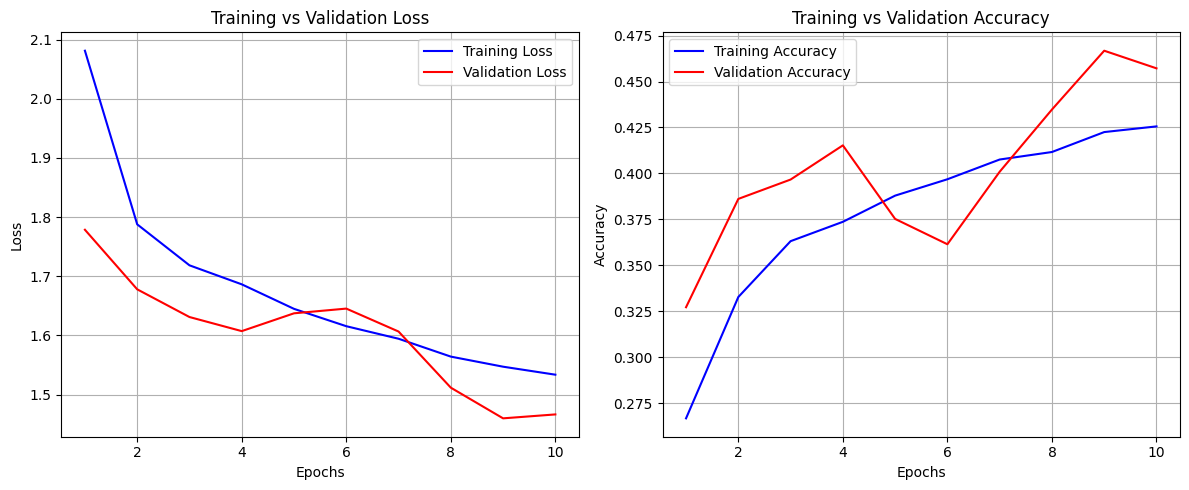

In [7]:
import matplotlib.pyplot as plt

# Extract training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')

epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# --- Loss Curve ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, 'b-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Accuracy Curve (if available) ---
if train_acc and val_acc:
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_tensor, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [14]:
model.save_weights("gnn_face_emotion.weights.h5")


Model Load functions

In [5]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from spektral.layers import GINConv
from spektral.utils.sparse import sp_matrix_to_sp_tensor
import scipy.sparse
import numpy as np

# Function to compute adjacency and sparse tensor

def get_mediapipe_adj_tensor():
    adj = get_mediapipe_adjacency_matrix()  # your existing function
    adj_sp = scipy.sparse.csr_matrix(adj)
    return sp_matrix_to_sp_tensor(adj_sp)

# Build function
def build_gnn_face_emotion_model(
    N: int,
    F: int,
    n_out: int,
    l2_reg: float = 5e-4,
    learning_rate: float = 1e-3
) -> tf.keras.Model:
    """
    Builds and compiles the GNN face emotion classification model.

    Args:
        N: Number of nodes (e.g., 468).
        F: Feature dimensionality per node (e.g., 2 for x, y).
        n_out: Number of emotion classes.
        l2_reg: L2 regularization factor.
        learning_rate: Learning rate for the Adam optimizer.

    Returns:
        A compiled tf.keras.Model instance.
    """
    # Prepare adjacency as sparse tensor
    adj_tensor = get_mediapipe_adj_tensor()

    # Input for node features
    X_in = Input(shape=(N, F), name='node_features')

    # First GNN block
    x = GINConv(64, activation='relu', kernel_regularizer=l2(l2_reg))([X_in, adj_tensor])
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Second GNN block
    x = GINConv(32, activation='relu', kernel_regularizer=l2(l2_reg))([x, adj_tensor])
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Global pooling (flatten)
    x = Flatten()(x)

    # Dense layers
    x = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output
    output = Dense(n_out, activation='softmax', name='emotion_output')(x)

    # Model
    model = Model(inputs=X_in, outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Example usage:
# model = build_gnn_face_emotion_model(N=468, F=2, n_out=6)
# model.summary()


In [6]:
# (Re)define your `build_model()` exactly as you did originally,
# including the `get_mediapipe_adjacency_matrix() + sp_matrix_to_sp_tensor` call.
model = build_gnn_face_emotion_model(N=468, F=2, n_out=6)  
model.load_weights("gnn_face_emotion2.weights.h5")

c:\Users\Dell\OneDrive - vit.ac.in\Documents\Projects\Emotion_counselling\.venv\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
from spektral.layers import GINConv
from spektral.utils.sparse import sp_matrix_to_sp_tensor
import scipy.sparse
from mediapipe.python.solutions.face_mesh_connections import FACEMESH_TESSELATION
import time

def get_mediapipe_adjacency_matrix():
    """Create adjacency matrix from MediaPipe face mesh connections"""
    # MediaPipe face mesh has 468 landmarks (without iris when refine_landmarks=False)
    n_nodes = 468
    adj_matrix = np.zeros((n_nodes, n_nodes), dtype=np.float32)
    
    # Add edges based on MediaPipe face mesh connections
    for connection in FACEMESH_TESSELATION:
        i, j = connection[0], connection[1]
        if i < n_nodes and j < n_nodes:  # Ensure indices are valid for 468 landmarks
            adj_matrix[i, j] = 1.0
            adj_matrix[j, i] = 1.0  # Undirected graph
    
    # Add self-loops
    np.fill_diagonal(adj_matrix, 1.0)
    
    return adj_matrix

# --- Constants and Initializations ---
# Define the emotion labels in the same order as your training data
EMOTIONS = ["Angry", "Disgusted", "Happy", "Neutral", "Sad", "Surprised"]

# Emotion colors for display (BGR format for OpenCV)
EMOTION_COLORS = {
    "Angry": (0, 0, 255),      # Red
    "Disgusted": (0, 128, 0),  # Green
    "Happy": (0, 255, 255),    # Yellow
    "Neutral": (128, 128, 128), # Gray
    "Sad": (255, 0, 0),        # Blue
    "Surprised": (0, 165, 255) # Orange
}

# Load the trained model with improved method
try:
    print("Loading trained GNN model...")
    from model_utils import load_model_with_validation
    model, metadata, adj_tensor_loaded = load_model_with_validation("emotion_gnn_model.h5")
    
    if model is None:
        print("❌ Could not load model. Make sure you've trained the model first.")
        exit()
        
    print("✅ Model loaded successfully.")
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Make sure 'emotion_gnn_model.h5' exists and was trained with the GNN code.")
    exit()

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1, 
    refine_landmarks=False,  # Use 468 landmarks (no iris)
    min_detection_confidence=0.7, 
    min_tracking_confidence=0.5
)

# Create adjacency matrix for the model
print("Creating adjacency matrix...")
adj_matrix = get_mediapipe_adjacency_matrix()
adj_sparse = scipy.sparse.csr_matrix(adj_matrix)
adj_tensor = sp_matrix_to_sp_tensor(adj_sparse)

print(f"Adjacency matrix shape: {adj_matrix.shape}")
print(f"Number of edges: {np.sum(adj_matrix > 0) // 2}")

# Prediction smoothing
prediction_history = []
history_size = 5  # Number of frames to average for smoothing

def normalize_mesh_points(mesh_points):
    """Normalize mesh points to match training data preprocessing"""
    mesh_points = np.array(mesh_points, dtype=np.float32)
    
    # Center the points
    center = np.mean(mesh_points, axis=0)
    mesh_points = mesh_points - center
    
    # Scale to unit variance
    scale = np.std(mesh_points)
    if scale > 0:
        mesh_points = mesh_points / scale
    
    return mesh_points

def draw_prediction_bars(frame, predictions, current_emotion):
    """Draw probability bars for all emotions"""
    bar_width = 200
    bar_height = 25
    start_x = 10
    start_y = 80
    
    for i, (emotion, prob) in enumerate(zip(EMOTIONS, predictions[0])):
        y_pos = start_y + i * (bar_height + 5)
        
        # Background bar
        cv2.rectangle(frame, (start_x, y_pos), (start_x + bar_width, y_pos + bar_height), 
                     (50, 50, 50), -1)
        
        # Probability bar
        fill_width = int(bar_width * prob)
        color = EMOTION_COLORS[emotion] if emotion == current_emotion else (100, 100, 100)
        cv2.rectangle(frame, (start_x, y_pos), (start_x + fill_width, y_pos + bar_height), 
                     color, -1)
        
        # Text label
        cv2.putText(frame, f"{emotion}: {prob:.1%}", (start_x + bar_width + 10, y_pos + 18), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

# --- Main Webcam Loop ---
print("Starting webcam...")
print("Press 'q' to quit, 's' to save current frame, 'r' to reset prediction history")

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("❌ Error: Could not open webcam.")
    exit()

# Set camera properties for better performance
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(cv2.CAP_PROP_FPS, 30)

frame_count = 0
fps_start_time = time.time()
fps = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    frame_count += 1
    H, W, _ = frame.shape
    
    # Calculate FPS
    if frame_count % 30 == 0:
        fps_end_time = time.time()
        fps = 30 / (fps_end_time - fps_start_time)
        fps_start_time = fps_end_time

    # Flip frame horizontally for mirror effect
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Process the frame with MediaPipe
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        # Use the landmarks of the first detected face
        face_landmarks = results.multi_face_landmarks[0]
        
        # --- Extract and preprocess landmarks for the model ---
        # 1. Extract X, Y coordinates
        mesh_points = np.array(
            [[p.x * W, p.y * H] for p in face_landmarks.landmark],
            dtype=np.float32
        )
        
        print(f"Number of landmarks detected: {len(mesh_points)}")  # Should be 468
        
        # 2. Normalize the landmarks (same as training)
        normalized_points = normalize_mesh_points(mesh_points)
        
        # 3. Reshape for the model input (add batch dimension)
        model_input = np.expand_dims(normalized_points, axis=0)
        
        try:
            # --- Predict Emotion ---
            prediction = model.predict(model_input, verbose=0)
            
            # Add to prediction history for smoothing
            prediction_history.append(prediction[0])
            if len(prediction_history) > history_size:
                prediction_history.pop(0)
            
            # Average predictions for smoother results
            smoothed_prediction = np.mean(prediction_history, axis=0)
            emotion_index = np.argmax(smoothed_prediction)
            emotion_label = EMOTIONS[emotion_index]
            confidence = smoothed_prediction[emotion_index]
            
            # --- Display the result on the frame ---
            # Draw face bounding box
            x_min = int(np.min(mesh_points[:, 0])) - 20
            y_min = int(np.min(mesh_points[:, 1])) - 20
            x_max = int(np.max(mesh_points[:, 0])) + 20
            y_max = int(np.max(mesh_points[:, 1])) + 20
            
            # Draw bounding box with emotion color
            color = EMOTION_COLORS[emotion_label]
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, 3)
            
            # Display the emotion label and confidence
            text = f"{emotion_label}: {confidence:.1%}"
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2)[0]
            
            # Background for text
            cv2.rectangle(frame, (x_min, y_min - 40), 
                         (x_min + text_size[0] + 10, y_min), color, -1)
            
            # Text
            cv2.putText(frame, text, (x_min + 5, y_min - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Draw face mesh (optional - can be disabled for better performance)
            # mp_drawing.draw_landmarks(
            #     frame, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS,
            #     landmark_drawing_spec=None,
            #     connection_drawing_spec=mp_drawing.DrawingSpec(
            #         color=(0, 255, 0), thickness=1, circle_radius=1)
            # )
            
            # Draw prediction bars
            draw_prediction_bars(frame, [smoothed_prediction], emotion_label)
            
        except Exception as e:
            print(f"Prediction error: {e}")
            cv2.putText(frame, "Prediction Error", (20, 40), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    else:
        cv2.putText(frame, "No Face Detected", (20, 40), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        # Clear prediction history when no face is detected
        prediction_history.clear()

    # Display FPS
    cv2.putText(frame, f"FPS: {fps:.1f}", (W - 120, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Display instructions
    cv2.putText(frame, "Press 'q' to quit, 'r' to reset", (10, H - 20), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Show the final frame
    cv2.imshow('Facial Emotion Recognition (GNN)', frame)

    # Handle key presses
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('r'):
        prediction_history.clear()
        print("Prediction history reset")
    elif key == ord('s'):
        filename = f"emotion_frame_{int(time.time())}.jpg"
        cv2.imwrite(filename, frame)
        print(f"Frame saved as {filename}")

print("Shutting down...")

# --- Cleanup ---
cap.release()
cv2.waitKey(1) 
cv2.destroyAllWindows()
cv2.waitKey(1)
face_mesh.close()

print("✅ Application closed successfully.")

Loading trained GNN model...
❌ Error loading model: No module named 'model_utils'
Make sure 'emotion_gnn_model.h5' exists and was trained with the GNN code.
Creating adjacency matrix...
Adjacency matrix shape: (468, 468)
Number of edges: 1556
Starting webcam...
Press 'q' to quit, 's' to save current frame, 'r' to reset prediction history


d:\hask\myenv\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of land

: 